In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, ReLU, SeparableConv2D, MaxPool2D, Add, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-04 17:24:54.488232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 17:24:54.488334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 17:24:54.655900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
fpath = "/kaggle/input/stanford-dogs-dataset/images/Images"
random_seed = 42

categories = os.listdir(fpath)

# taking only first 20 categories
categories = categories[:20]

In [3]:
import re

pattern = r"-(\w[\w-]*)$"

# Extract dog names from the list
dog_names = []
for category in categories:
    match = re.search(pattern, category)
    if match:
        dog_names.append(match.group(1))

# Print the extracted dog names
print("Extracted dog names:", dog_names)
print("Total dog breeds: ", len(dog_names))

Extracted dog names: ['otterhound', 'cocker_spaniel', 'Brittany_spaniel', 'Afghan_hound', 'Maltese_dog', 'schipperke', 'Irish_setter', 'Pekinese', 'golden_retriever', 'vizsla', 'Welsh_springer_spaniel', 'Staffordshire_bullterrier', 'Border_collie', 'Irish_terrier', 'Eskimo_dog', 'pug', 'kelpie', 'Yorkshire_terrier', 'Tibetan_terrier', 'Walker_hound']
Total dog breeds:  20


In [4]:
def create_mapping(dog_breeds):
    breed_to_nclass = {}
    nclass_to_breed = {}
    for num_class, breed in enumerate(dog_breeds):
        breed_to_nclass[breed] = num_class
        nclass_to_breed[num_class] = breed
    return breed_to_nclass, nclass_to_breed

In [5]:
breed_to_nclass, nclass_to_breed = create_mapping(dog_names)

In [6]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            resized_img = img_array.resize((299, 299))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  3365 
No. of labels loaded =  3365
<class 'list'> <class 'list'>


In [7]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (3365, 299, 299, 3) 
Labels shape =  (3365,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


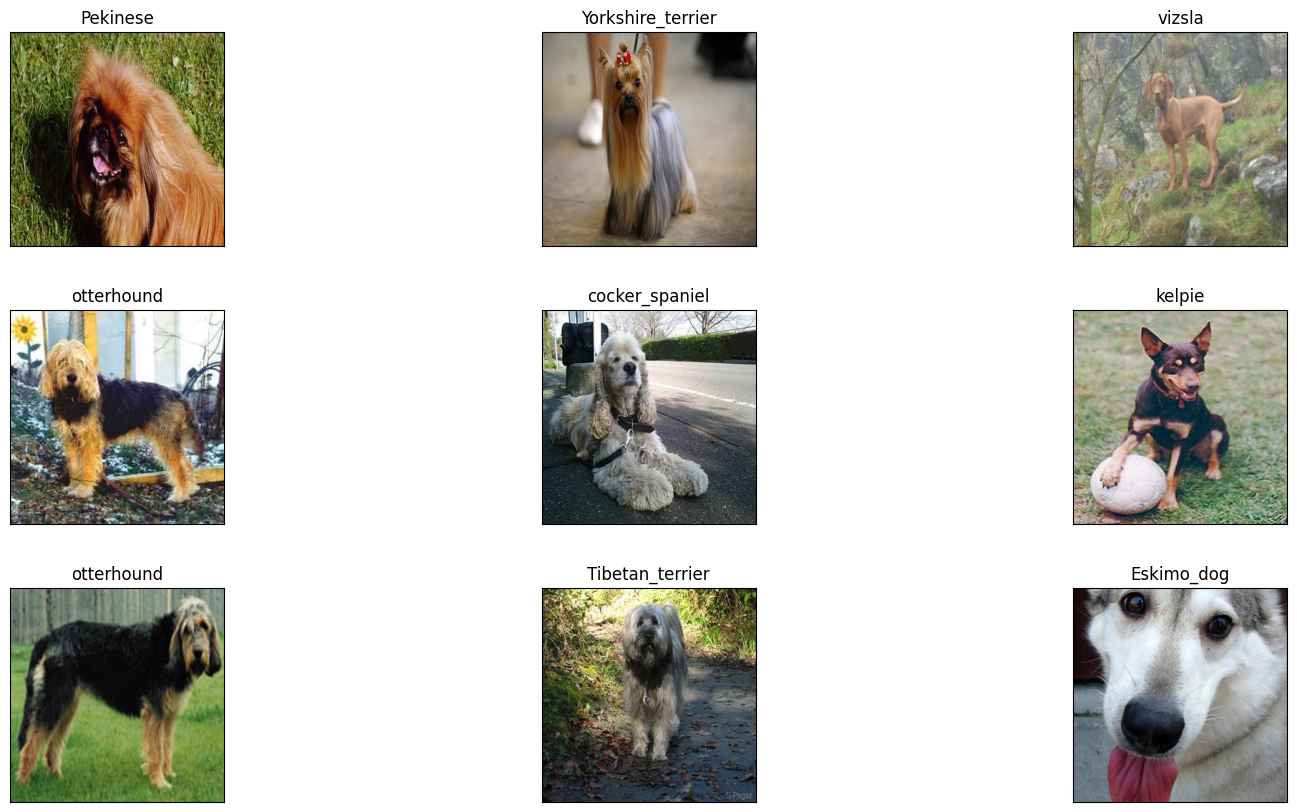

In [9]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title(nclass_to_breed[labels[r[0]]])
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

In [10]:
# shuffling the images

n = np.arange(images.shape[0])
np.random.seed(42)
np.random.shuffle(n)
images = images[n]
labels = labels[n]

In [11]:
# splitting the data

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)


x_train shape =  (2692, 299, 299, 3)
y_train shape =  (2692,)

x_test shape =  (673, 299, 299, 3)
y_test shape =  (673,)


In [12]:
data_augmentation = keras.Sequential([keras.layers.RandomFlip("horizontal_and_vertical"),
                                      keras.layers.RandomRotation(factor=0.1),
                                      keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                                      keras.layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
                                      keras.layers.RandomBrightness(factor=0.1),
                                      keras.layers.RandomContrast(factor=0.1)])

In [13]:
# creating xception as it has less number of parameters and good performance

def xception(input_shape=(299, 299, 3), n_classes=20):

    def conv_bn(x, f, k, s=1, p='same'):
        x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
        x = BatchNormalization()(x)
        return x

    def sep_bn(x, f, k, s=1, p='same'):
        x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
        x = BatchNormalization()(x)
        return x

    def entry_flow(x):
        x = conv_bn(x, 32, 3, 2)
        x = ReLU()(x)
        x = conv_bn(x, 64, 3)
        tensor = ReLU()(x)

        x = sep_bn(tensor, 128, 3)
        x = ReLU()(x)
        x = sep_bn(x, 128, 3)
        x = MaxPool2D(3, strides=2, padding='same')(x)

        tensor = conv_bn(tensor, 128, 1, 2)

        x = Add()([tensor, x])
        x = ReLU()(x)
        x = sep_bn(x, 256, 3)
        x = ReLU()(x)
        x = sep_bn(x, 256, 3)
        x = MaxPool2D(3, strides=2, padding='same')(x)

        tensor = conv_bn(tensor, 256, 1, 2)

        x = Add()([tensor, x])
        x = ReLU()(x)
        x = sep_bn(x, 728, 3)
        x = ReLU()(x)
        x = sep_bn(x, 728, 3)
        x = MaxPool2D(3, strides=2, padding='same')(x)

        tensor = conv_bn(tensor, 728, 1, 2)
        x = Add()([tensor, x])

        return x

    def middle_flow(tensor):
        for _ in range(8):
            x = ReLU()(tensor)
            x = sep_bn(x, 728, 3)
            x = ReLU()(x)
            x = sep_bn(x, 728, 3)
            x = ReLU()(x)
            x = sep_bn(x, 728, 3)

            tensor = Add()([tensor, x])

        return tensor

    def exit_flow(tensor):
        x = ReLU()(tensor)
        x = sep_bn(x, 728, 3)
        x = ReLU()(x)
        x = sep_bn(x, 1024, 3)
        x = MaxPool2D(3, strides=2, padding='same')(x)

        tensor = conv_bn(tensor, 1024, 1, 2)

        x = Add()([tensor, x])
        x = sep_bn(x, 1536, 3)
        x = ReLU()(x)
        x = sep_bn(x, 2048, 3)
        x = ReLU()(x)
        x = GlobalAvgPool2D()(x)
        x = Dense(n_classes, activation='softmax')(x)

        return x

    input = keras.Input(input_shape)
    x = data_augmentation(input)
    x = entry_flow(x)
    x = middle_flow(x)
    output = exit_flow(x)

    model = keras.Model(input, output)

    return model

In [14]:
xception_model = xception()

In [15]:
xception_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        864 │ sequential[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     18,432 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 150, 150,  │      8,768 │ re_lu_1[0][0]     │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 150, 150,  │     17,536 │ re_lu_2[0][0]     │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │      8,192 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ batch_normalizat

 Total params: 20,902,460 (79.74 MB)

 Trainable params: 20,847,932 (79.53 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [19]:
# a model that I previously trained and saved for about 40 epochs in varoius sessions due to time constraints
xception_model = keras.models.load_model("/kaggle/input/xception/xception.keras")

In [20]:
xception_model.evaluate(x_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.5538 - loss: 2.1434


[2.219602346420288, 0.5690935850143433]

In [25]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="xception.keras",
    save_best_only=True,
    monitor="val_accuracy"),
 ]

In [26]:
xception_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [29]:
# training the previously saved model for 10 more epochs
history = xception_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=callbacks)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9065 - loss: 0.3287 - val_accuracy: 0.5186 - val_loss: 2.9749
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9438 - loss: 0.1676 - val_accuracy: 0.6018 - val_loss: 2.1272
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9680 - loss: 0.1064 - val_accuracy: 0.6033 - val_loss: 1.8105
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9374 - loss: 0.2069 - val_accuracy: 0.5810 - val_loss: 2.3643
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9523 - loss: 0.1324 - val_accuracy: 0.5973 - val_loss: 2.2663
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9652 - loss: 0.0997 - val_accuracy: 0.6330 - val_loss: 2.0443
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9270 - loss: 0.2763 - val_accuracy: 0.5527 - val_loss: 2.6659
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9508 - loss: 0.1484 - val_accuracy: 0.5780 - v

In [30]:
best_model = keras.models.load_model("xception.keras")
best_model.evaluate(x_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.6341 - loss: 2.0586


[2.044283151626587, 0.6329866051673889]